In [41]:

import numpy as np 
import scipy
import math 
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 

#k strike 
#q dividend rate 
#sigma is the standard deviation 
#reference on Halleys Method: https://www.jstor.org/stable/pdf/2321760.pdf


def black_scholes_call(t, T, s, k, r, sigma, q = 0):
    d1 = ( np.log(s/k) + (r - q + 0.5*sigma**2)*(T-t) )/(sigma * np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)
    price = s * np.exp(-q *(T-t))*scipy.stats.norm.cdf(d1) - k*np.exp(-r *(T-t))*scipy.stats.norm.cdf(d2)
    return price




def calc_d1(t, T, s, k, r, sigma):
    return ( np.log(s/k) + (r  + 0.5*sigma**2)*(T-t) )/(sigma * np.sqrt(T-t))



def df_option(t, T, s, k, r, sigma):
    d1 = calc_d1(t, T, s, k, r, sigma)
    return s * scipy.stats.norm.pdf(d1) * np.sqrt(T-t)


def implied_vol(PriceCall, t, T, S, K, r, start, method = "newton"):
   
    epsilon = 10**(-5.5)
    old = start
    diff, gap_price = 1, 1
    
    if method == "newton":
        while diff > epsilon:
            gap_price = black_scholes_call(t,T,S, K, r, old ) - PriceCall
            new = old - gap_price/df_option(t, T, S, K, r, old)
            diff = np.abs(new - old)
            old = new
        return old, gap_price
    
    if method == "halleys":
        while diff > epsilon:
                gap_price = black_scholes_call(t,T,S, K, r, old ) - PriceCall
                vega = df_option(t, T, S, K, r, old)
                d1 = calc_d1(t, T, S, K, r, old)
                vomma = vega*d1*(d1 - old *np.sqrt(T-t))/old
                denominator = 2*vega**2 - gap_price * vomma
                
                new = old - 2*vega*gap_price/denominator
                diff = np.abs(new - old)
                old = new  
        return old, gap_price
    
    
        


def implied_stock(PriceCall, t, T, start, K, r, sigma, method = "newton"):
    epsilon = 10**(-5)
    old = start
    diff = 1
    if method == "newton":
        while diff > epsilon:
            gap_price = black_scholes_call(t,T,old, K, r, sigma ) - PriceCall
            d1 = calc_d1(t, T, old, K, r, sigma)
            delta = scipy.stats.norm.cdf(d1)
            new = old - gap_price/delta
            diff = np.abs(new - old)
            old = new
        return old, gap_price
    
    if method == "halleys":
        while diff > epsilon:
            gap_price = black_scholes_call(t,T,old, K, r, sigma ) - PriceCall
            d1 = calc_d1(t, T, old, K, r, sigma)
            delta = scipy.stats.norm.cdf(d1)
            gamma = scipy.stats.norm.pdf(d1)/(sigma * old* np.sqrt(T-t))
            denominator = 2*delta**2 - gap_price * gamma
            new = old - 2*delta*gap_price/denominator
            diff = np.abs(new - old)
            old = new
        return old, gap_price

    


In [42]:
#EXERCISE 1

t_ = 0
T_ = 10
s_ = 100
k_ = 70
r_ = 0.04
sigma_ = 0.3

#compute the current value of the firm equity 
EqValue = black_scholes_call(t = t_, T = T_, s = s_, k = k_, r = r_, sigma = sigma_)
print(f"Equity Value: {EqValue}")

def coupon_option(t, S, K1, T1, K2, T2, r, sigma, method ):
    
    S_star, precision = implied_stock( K1, T1, T2, 20, K2, r, sigma, method)
    print(f"Precision S_star : {precision}")
    a1 = (np.log(S/S_star) + (r + sigma**2 / 2)*(T1 - t))/np.sqrt((T1-t) * sigma**2)
    a2 = a1 - sigma * np.sqrt(T1 - t)
    b1 = (np.log(S/K2) + (r + sigma**2 / 2)*(T2- t))/np.sqrt((T2-t) * sigma**2)
    b2 = b1 - sigma * np.sqrt(T2 - t)
    
  
    rho = np.sqrt(T1 - t)/np.sqrt(T2 - t)
    covariance = np.diag( np.ones(2))
    covariance[0,1] = rho
    covariance[1,0] = rho 
    mu = np.zeros(2)
    
    n2_first = multivariate_normal.cdf(np.array([a1, b1]), mean = mu, cov = covariance)
    n2_second = multivariate_normal.cdf(np.array([a2, b2]), mean = mu, cov = covariance)
    n = scipy.stats.norm.cdf(a2)
    
    return S*n2_first - K2 * np.exp(-r*(T2-t)) * n2_second - np.exp(-r *(T1 - t))*K1*n


        

Equity Value: 60.421681620226636


In [43]:
K = EqValue * np.array([0.6, 0.8, 1, 1.2])
maturities = np.array([2, 4,6,8])
prices = np.zeros( (len(K), len(maturities)) )

for row, strike in enumerate(K): 
    for column, m in enumerate(maturities):
        prices[row, column] = coupon_option(t = t_, S = s_, K1 = strike, T1 = m,  K2 = k_, 
                                            T2 = T_, r = r_, sigma = sigma_, method = "halleys" )
       
        


Precision S_star : -1.9184653865522705e-13
Precision S_star : -1.859559262129551e-08
Precision S_star : -2.7000623958883807e-13
Precision S_star : -2.273286277443276e-06
Precision S_star : -1.858779796748422e-11
Precision S_star : -4.4599977400139323e-07
Precision S_star : -2.7334579044691054e-11
Precision S_star : -7.105427357601002e-15
Precision S_star : -3.831388539765612e-10
Precision S_star : -3.7170261606433996e-06
Precision S_star : -5.624229970635497e-10
Precision S_star : 0.0
Precision S_star : -3.375447477083071e-09
Precision S_star : 0.0
Precision S_star : -4.790635443896463e-09
Precision S_star : -1.4210854715202004e-14


each row is a strike, each colum in a different maturity
Prices: 
 [[30.09257145 35.48638668 39.92173895 43.79228966]
 [22.84127532 29.73405956 35.14161533 39.75548903]
 [17.15309031 24.96334311 31.03980219 36.19444462]
 [12.7956055  21.00601149 27.50035303 33.03497058]]


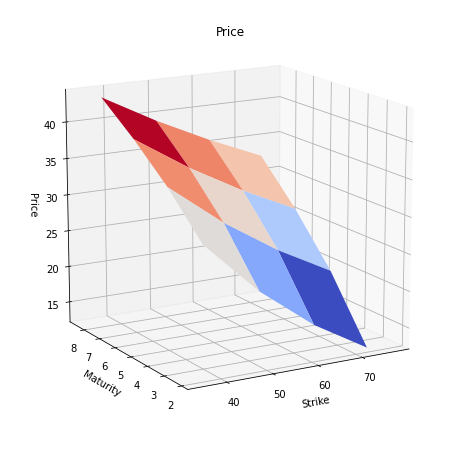

In [44]:
x, y = np.meshgrid(K, maturities, indexing = "ij" )
z = prices 
print("each row is a strike, each colum in a different maturity")
print("Prices: \n", prices)


from matplotlib import cm
#we can also visualize the price 
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = '3d')
ax.view_init(15, 60)
ax.set_xlim(K.max()*1.1,K.min()*0.90)
ax.set_ylim(maturities.max()*1.1, maturities.min()*0.9)
ax.set_title("Price")
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
ax.set_zlabel("Price")
  
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

Precision:   7.101874643922201e-12
Precision:   2.9984903449076228e-12
Precision:   1.1127099242003169e-11
Precision:   3.894484734701109e-11
Precision:   0.0
Precision:   8.881784197001252e-14
Precision:   2.7924329515371937e-12
Precision:   3.572608875401784e-11
Precision:   1.4606955055285198e-05
Precision:   3.552713678800501e-15
Precision:   1.0977885267493548e-12
Precision:   3.5555558497435413e-11
Precision:   2.3112833641647512e-05
Precision:   7.105427357601002e-15
Precision:   8.597567102697212e-13
Precision:   4.243361217959318e-11

Implied vol
 [[0.48071324 0.49617877 0.5152732  0.54049228]
 [0.46725672 0.48122146 0.49824092 0.52014435]
 [0.45694852 0.46974276 0.48515589 0.50454412]
 [0.44865392 0.46049656 0.47461489 0.49202153]]


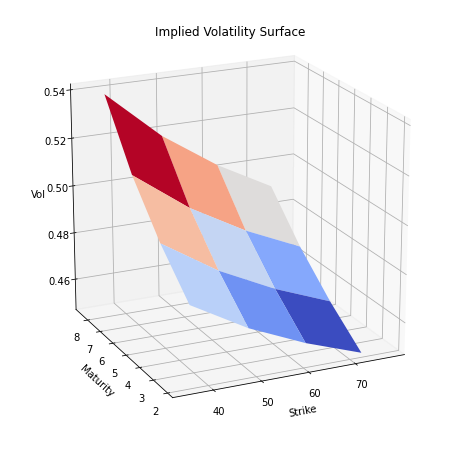

In [45]:
#we can now calculate the implied volatility 

vol = np.zeros( (len(K), len(maturities)) )
for row, strike in enumerate(K): 
    for column, m in enumerate(maturities):
        vol[row, column], precision = implied_vol(PriceCall = prices[row, column], t = t_,  
                                                  T = m, S = EqValue, K = strike, r = r_, 
                                                  start = 1,  method = "halleys")
        print("Precision:  ",precision)


        

x, y = np.meshgrid(K, maturities, indexing = "ij" )
z = vol

#we can also visualize the price 
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = '3d')
ax.view_init(20, 65)
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
ax.set_title("Implied Volatility Surface")
ax.set_zlabel("Vol")
ax.set_xlim(K.max()*1.1,K.min()*0.90)
ax.set_ylim(maturities.max()*1.1, maturities.min()*0.9)
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)


print("\nImplied vol\n", vol)


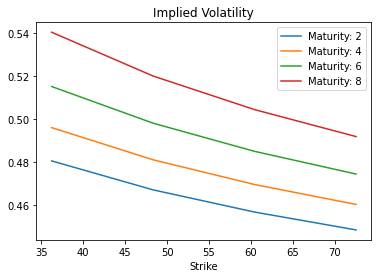

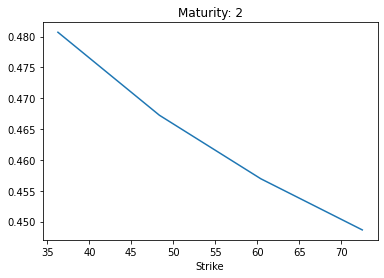

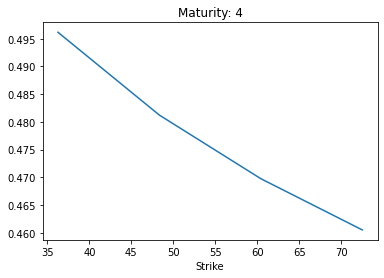

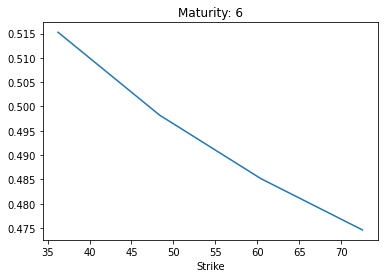

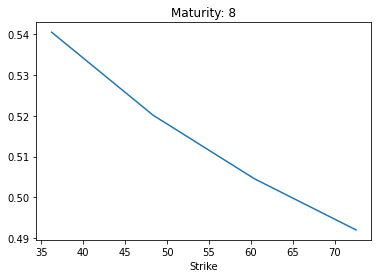

In [46]:
#for each maturity plot the implied volatility as function of the strike 

for column, maturity in enumerate(maturities):
    plt.title("Implied Volatility")
    x = K
    y = vol[:, column]
    plt.xlabel("Strike")
    plt.plot(x, y, label = f"Maturity: {maturity}")
    plt.legend()
    
plt.show()

for column, maturity in enumerate(maturities):
    plt.title(f"Maturity: {maturity}")
    x = K
    y = vol[:, column]
    plt.plot(x, y)
    plt.xlabel("Strike")
    plt.show()
              

In [47]:
#EXERCISE 2


#EXERCISE 2
import math 
s_ , gamma_ , lam_ = 100, -0.07, 0.25
expirations = np.array([0.02, 0.08, 0.25, 0.5])
#strikes = np.array([0.8, 0.9, 1, 1.1]) * s_
strikes = np.array([0.4,0.6,0.7, 0.8,  0.9, 1, 1.1]) * s_
r_ = 0.05
sigma_ = 0.2


def probability(k, T, lam):
     return np.exp(-lam*T) * (1/factorial(k))* (lam *T)**k
    
def factorial(n):
        return np.array([math.factorial(j) for j in n])
        
        
def call_option_jump(t, T, s, k, r, sigma, gamma, lam, max_jump):

        jump = np.arange(0, max_jump+1)
        underlying = s * (1 - gamma)**jump
        price = black_scholes_call(t, T, underlying, k, r, sigma , q = - lam * gamma)
        weighted = probability(jump, T, lam) * price
        return weighted.sum()
    

prices_ = np.empty((len(strikes), len(expirations)))
for row, strike in enumerate(strikes):
    for column, exp in enumerate(expirations):
        prices_[row, column] = call_option_jump(t = 0, T = exp, s = s_, k = strike, 
                                               r = r_, sigma = sigma_, gamma = gamma_, lam = lam_, 
                                               max_jump = 10)
                   
print("Prices:\n",prices_, "\n") 

vol_ = np.empty((len(strikes), len(expirations)))
for row, strike in enumerate(strikes):
    for column, exp in enumerate(expirations):
        
        vol_[row, column], precision = implied_vol(PriceCall = prices_[row, column], t = t_,  
                                                  T = exp, S = s_, K = strike, r = r_, 
                                                  start = 1,  method = "halleys")
        print("Precision:  ",precision)


                   
print("\nPrices:\n",vol_) 
        

    

Prices:
 [[6.00399800e+01 6.01596804e+01 6.04968880e+01 6.09876035e+01]
 [4.00599700e+01 4.02395206e+01 4.07453321e+01 4.14816284e+01]
 [3.00699650e+01 3.02794407e+01 3.08698050e+01 3.17419689e+01]
 [2.00799600e+01 2.03193977e+01 2.10233529e+01 2.21867417e+01]
 [1.00900116e+01 1.04160175e+01 1.16912544e+01 1.35421894e+01]
 [1.18992438e+00 2.48614821e+00 4.66927965e+00 6.96563624e+00]
 [1.75689889e-03 1.49902439e-01 1.24160863e+00 2.98690831e+00]] 

Precision:   0.0
Precision:   0.0
Precision:   0.0
Precision:   7.105427357601002e-15
Precision:   0.0
Precision:   0.0
Precision:   7.773337529215496e-12
Precision:   1.446167630092532e-10
Precision:   0.0
Precision:   -1.4210854715202004e-14
Precision:   5.7909232964448165e-12
Precision:   4.2129958188752425e-08
Precision:   0.0
Precision:   -1.7763568394002505e-14
Precision:   2.7746693831431912e-12
Precision:   2.860971903828613e-09
Precision:   3.33262306639881e-11
Precision:   4.561880118103545e-08
Precision:   2.020921067824588e-06
Pr


Implied vol
 [[0.48071324 0.49617877 0.5152732  0.54049228]
 [0.46725672 0.48122146 0.49824092 0.52014435]
 [0.45694852 0.46974276 0.48515589 0.50454412]
 [0.44865392 0.46049656 0.47461489 0.49202153]]


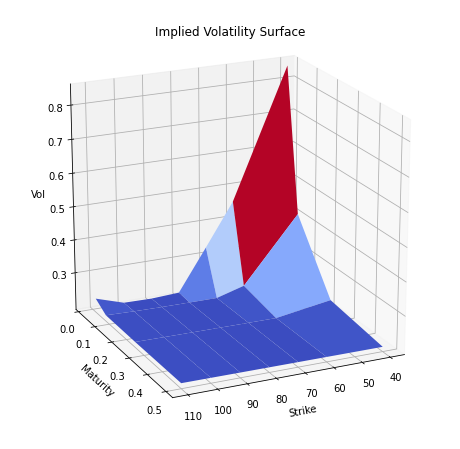

In [48]:

x, y = np.meshgrid(strikes, expirations, indexing = "ij" )
z = vol_

#we can also visualize the price 
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = '3d')
ax.view_init(20, 65)
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
ax.set_title("Implied Volatility Surface")
ax.set_zlabel("Vol")
#ax.set_xlim(strikes.max()*1.1,strikes.min()*0.90)
#ax.set_ylim(expirations.max()*1.1, expirations.min()*0.9)
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)


print("\nImplied vol\n", vol)


Implied vol
 [[0.48071324 0.49617877 0.5152732  0.54049228]
 [0.46725672 0.48122146 0.49824092 0.52014435]
 [0.45694852 0.46974276 0.48515589 0.50454412]
 [0.44865392 0.46049656 0.47461489 0.49202153]]


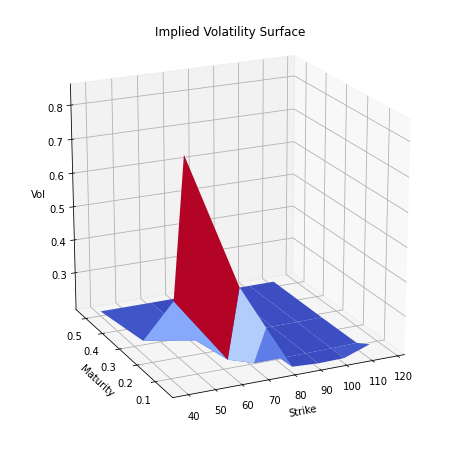

In [49]:
x, y = np.meshgrid(strikes, expirations, indexing = "ij" )
z = vol_

#we can also visualize the price 
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = '3d')
ax.view_init(20, 65)
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
ax.set_title("Implied Volatility Surface")
ax.set_zlabel("Vol")
ax.set_xlim(strikes.max()*1.1,strikes.min()*0.90)
ax.set_ylim(expirations.max()*1.1, expirations.min()*0.9)
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)


print("\nImplied vol\n", vol)

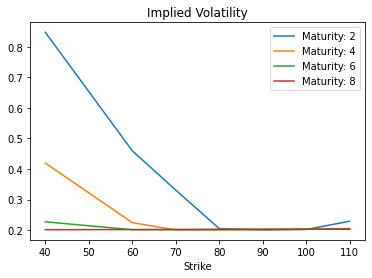

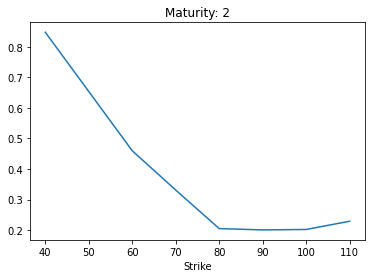

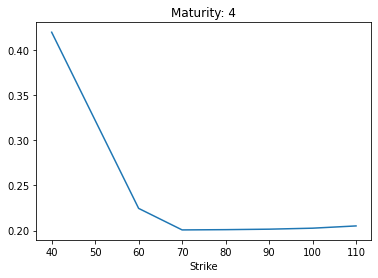

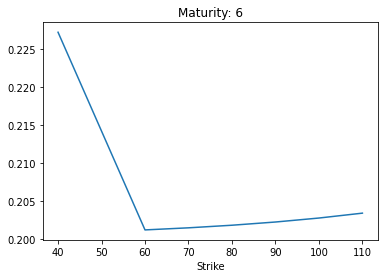

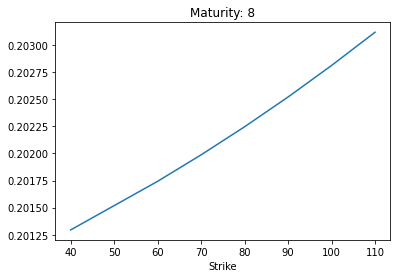

In [50]:
for column, maturity in enumerate(maturities):
    plt.title("Implied Volatility")
    x = strikes
    y = vol_[:, column]
    plt.xlabel("Strike")
    plt.plot(x, y, label = f"Maturity: {maturity}")
    plt.legend()
    
plt.show()

for column, maturity in enumerate(maturities):
    plt.title(f"Maturity: {maturity}")
    x = strikes
    y = vol_[:, column]
    plt.plot(x, y)
    plt.xlabel("Strike")
    plt.show()
              